In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from os.path import join

import tensorflow as tf 
from tensorflow.keras import layers, models, optimizers, Input, Model
from tensorflow.keras.utils import to_categorical

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-05-10 21:00:01.592301: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-10 21:00:01.649125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 21:00:01.683332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 21:00:01.683434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5369025253941552415
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5934219264
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15752211138114335873
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
tf.config.list_physical_devices('GPU')

2022-05-10 21:00:01.978260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 21:00:01.978463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 21:00:01.978603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

(400,)


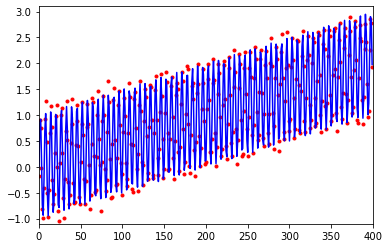

In [4]:
# sin 그래프 + 랜덤 노이즈(평균, 표준 편차, 개수)(additive noise) + 점진적 증가(gradually increasing) -> 앞에서 학습 뒤에서 테스트 하기 위해서+
data_time = np.sin(np.arange(400))+ np.random.normal(0, 0.1, 400) + np.arange(400)/200 
print(data_time.shape)
plt.plot(data_time,'r.')
plt.plot(range(400), np.sin(np.arange(400))+np.arange(400)/200, 'b')
plt.xlim(-0.5, 400.5)
plt.ylim(-1.1, 3.1)
plt.show()

In [5]:
data_matrix = []
seq_len = 3
for i in range(0, len(data_time)-seq_len):
    tmp_data = data_time[i:i+seq_len+1]
    data_matrix.append(tmp_data)

    data_matrix_np = np.array(data_matrix)
    print(data_matrix_np.shape)
    print(data_matrix_np)

(1, 4)
[[-0.16808225  0.89805117  0.75624254 -0.02629723]]
(2, 4)
[[-0.16808225  0.89805117  0.75624254 -0.02629723]
 [ 0.89805117  0.75624254 -0.02629723 -0.81238928]]
(3, 4)
[[-0.16808225  0.89805117  0.75624254 -0.02629723]
 [ 0.89805117  0.75624254 -0.02629723 -0.81238928]
 [ 0.75624254 -0.02629723 -0.81238928 -0.99262269]]
(4, 4)
[[-0.16808225  0.89805117  0.75624254 -0.02629723]
 [ 0.89805117  0.75624254 -0.02629723 -0.81238928]
 [ 0.75624254 -0.02629723 -0.81238928 -0.99262269]
 [-0.02629723 -0.81238928 -0.99262269 -0.40647046]]
(5, 4)
[[-0.16808225  0.89805117  0.75624254 -0.02629723]
 [ 0.89805117  0.75624254 -0.02629723 -0.81238928]
 [ 0.75624254 -0.02629723 -0.81238928 -0.99262269]
 [-0.02629723 -0.81238928 -0.99262269 -0.40647046]
 [-0.81238928 -0.99262269 -0.40647046  0.92401503]]
(6, 4)
[[-0.16808225  0.89805117  0.75624254 -0.02629723]
 [ 0.89805117  0.75624254 -0.02629723 -0.81238928]
 [ 0.75624254 -0.02629723 -0.81238928 -0.99262269]
 [-0.02629723 -0.81238928 -0.992622

(148, 4)
[[-0.16808225  0.89805117  0.75624254 -0.02629723]
 [ 0.89805117  0.75624254 -0.02629723 -0.81238928]
 [ 0.75624254 -0.02629723 -0.81238928 -0.99262269]
 [-0.02629723 -0.81238928 -0.99262269 -0.40647046]
 [-0.81238928 -0.99262269 -0.40647046  0.92401503]
 [-0.99262269 -0.40647046  0.92401503  1.28089025]
 [-0.40647046  0.92401503  1.28089025  0.48427341]
 [ 0.92401503  1.28089025  0.48427341 -0.49588909]
 [ 1.28089025  0.48427341 -0.49588909 -0.97196549]
 [ 0.48427341 -0.49588909 -0.97196549 -0.43816176]
 [-0.49588909 -0.97196549 -0.43816176  0.64791494]
 [-0.97196549 -0.43816176  0.64791494  1.17055636]
 [-0.43816176  0.64791494  1.17055636  0.77204439]
 [ 0.64791494  1.17055636  0.77204439 -0.26322967]
 [ 1.17055636  0.77204439 -0.26322967 -0.72251504]
 [ 0.77204439 -0.26322967 -0.72251504 -0.52823251]
 [-0.26322967 -0.72251504 -0.52823251  0.27611543]
 [-0.72251504 -0.52823251  0.27611543  0.97421848]
 [-0.52823251  0.27611543  0.97421848  1.19864142]
 [ 0.27611543  0.97421

[[-0.16808225  0.89805117  0.75624254 -0.02629723]
 [ 0.89805117  0.75624254 -0.02629723 -0.81238928]
 [ 0.75624254 -0.02629723 -0.81238928 -0.99262269]
 [-0.02629723 -0.81238928 -0.99262269 -0.40647046]
 [-0.81238928 -0.99262269 -0.40647046  0.92401503]
 [-0.99262269 -0.40647046  0.92401503  1.28089025]
 [-0.40647046  0.92401503  1.28089025  0.48427341]
 [ 0.92401503  1.28089025  0.48427341 -0.49588909]
 [ 1.28089025  0.48427341 -0.49588909 -0.97196549]
 [ 0.48427341 -0.49588909 -0.97196549 -0.43816176]
 [-0.49588909 -0.97196549 -0.43816176  0.64791494]
 [-0.97196549 -0.43816176  0.64791494  1.17055636]
 [-0.43816176  0.64791494  1.17055636  0.77204439]
 [ 0.64791494  1.17055636  0.77204439 -0.26322967]
 [ 1.17055636  0.77204439 -0.26322967 -0.72251504]
 [ 0.77204439 -0.26322967 -0.72251504 -0.52823251]
 [-0.26322967 -0.72251504 -0.52823251  0.27611543]
 [-0.72251504 -0.52823251  0.27611543  0.97421848]
 [-0.52823251  0.27611543  0.97421848  1.19864142]
 [ 0.27611543  0.97421848  1.19

[[-0.16808225  0.89805117  0.75624254 -0.02629723]
 [ 0.89805117  0.75624254 -0.02629723 -0.81238928]
 [ 0.75624254 -0.02629723 -0.81238928 -0.99262269]
 [-0.02629723 -0.81238928 -0.99262269 -0.40647046]
 [-0.81238928 -0.99262269 -0.40647046  0.92401503]
 [-0.99262269 -0.40647046  0.92401503  1.28089025]
 [-0.40647046  0.92401503  1.28089025  0.48427341]
 [ 0.92401503  1.28089025  0.48427341 -0.49588909]
 [ 1.28089025  0.48427341 -0.49588909 -0.97196549]
 [ 0.48427341 -0.49588909 -0.97196549 -0.43816176]
 [-0.49588909 -0.97196549 -0.43816176  0.64791494]
 [-0.97196549 -0.43816176  0.64791494  1.17055636]
 [-0.43816176  0.64791494  1.17055636  0.77204439]
 [ 0.64791494  1.17055636  0.77204439 -0.26322967]
 [ 1.17055636  0.77204439 -0.26322967 -0.72251504]
 [ 0.77204439 -0.26322967 -0.72251504 -0.52823251]
 [-0.26322967 -0.72251504 -0.52823251  0.27611543]
 [-0.72251504 -0.52823251  0.27611543  0.97421848]
 [-0.52823251  0.27611543  0.97421848  1.19864142]
 [ 0.27611543  0.97421848  1.19

In [6]:
datax = data_matrix_np[:,0:3]
datay = data_matrix_np[:,3]
print(datax.shape)
print(datay.shape)

(397, 3)
(397,)


In [7]:
trnx = datax[0:300, :]
trny = datay[0:300]
tstx = datax[300:datax.shape[0],:]
tsty = datay[300:datax.shape[0]]
print(trnx.shape)
print(tstx.shape)
print(trny.shape)
print(tsty.shape)

(300, 3)
(97, 3)
(300,)
(97,)


In [8]:
input_shape = (3,)
mlp_model = models.Sequential()
mlp_model.add(layers.Dense(units = 5, activation = 'tanh', input_shape=input_shape))
mlp_model.add(layers.Dense(units = 10, activation = 'tanh'))
mlp_model.add(layers.Dense(units = 1, activation = 'linear'))

mlp_model.compile(optimizer='Adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])

2022-05-10 21:00:02.458815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 21:00:02.458960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 21:00:02.459012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 21:00:02.459092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 21:00:02.459141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [9]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 20        
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = mlp_model.fit(trnx, trny, validation_data = [tstx, tsty], batch_size = 10, epochs = 300)

Epoch 1/300
30/30 [==============================] - 1s 3ms/step - loss: 0.8854 - mean_squared_error: 0.8854 - val_loss: 1.7129 - val_mean_squared_error: 1.7129
Epoch 2/300
30/30 [==============================] - 0s 1ms/step - loss: 0.5575 - mean_squared_error: 0.5575 - val_loss: 1.1242 - val_mean_squared_error: 1.1242
Epoch 3/300
30/30 [==============================] - 0s 1ms/step - loss: 0.3440 - mean_squared_error: 0.3440 - val_loss: 0.8153 - val_mean_squared_error: 0.8153
Epoch 4/300
30/30 [==============================] - 0s 1ms/step - loss: 0.2147 - mean_squared_error: 0.2147 - val_loss: 0.6635 - val_mean_squared_error: 0.6635


2022-05-10 21:00:03.217166: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 5/300
30/30 [==============================] - 0s 1ms/step - loss: 0.1555 - mean_squared_error: 0.1555 - val_loss: 0.5082 - val_mean_squared_error: 0.5082
Epoch 6/300
30/30 [==============================] - 0s 1ms/step - loss: 0.1299 - mean_squared_error: 0.1299 - val_loss: 0.4521 - val_mean_squared_error: 0.4521
Epoch 7/300
30/30 [==============================] - 0s 1ms/step - loss: 0.1197 - mean_squared_error: 0.1197 - val_loss: 0.4031 - val_mean_squared_error: 0.4031
Epoch 8/300
30/30 [==============================] - 0s 2ms/step - loss: 0.1148 - mean_squared_error: 0.1148 - val_loss: 0.3514 - val_mean_squared_error: 0.3514
Epoch 9/300
30/30 [==============================] - 0s 2ms/step - loss: 0.1105 - mean_squared_error: 0.1105 - val_loss: 0.3521 - val_mean_squared_error: 0.3521
Epoch 10/300
30/30 [==============================] - 0s 2ms/step - loss: 0.1065 - mean_squared_error: 0.1065 - val_loss: 0.3034 - val_mean_squared_error: 0.3034
Epoch 11/300
30/30 [=============

30/30 [==============================] - 0s 2ms/step - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.1757 - val_mean_squared_error: 0.1757
Epoch 56/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0888 - mean_squared_error: 0.0888 - val_loss: 0.1681 - val_mean_squared_error: 0.1681
Epoch 57/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.1963 - val_mean_squared_error: 0.1963
Epoch 58/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0884 - mean_squared_error: 0.0884 - val_loss: 0.1734 - val_mean_squared_error: 0.1734
Epoch 59/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0882 - mean_squared_error: 0.0882 - val_loss: 0.1815 - val_mean_squared_error: 0.1815
Epoch 60/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.1527 - val_mean_squared_error: 0.1527
Epoch 61/300
30/30 [=====================

30/30 [==============================] - 0s 2ms/step - loss: 0.0843 - mean_squared_error: 0.0843 - val_loss: 0.1240 - val_mean_squared_error: 0.1240
Epoch 106/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0850 - mean_squared_error: 0.0850 - val_loss: 0.1681 - val_mean_squared_error: 0.1681
Epoch 107/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0839 - mean_squared_error: 0.0839 - val_loss: 0.1743 - val_mean_squared_error: 0.1743
Epoch 108/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0837 - mean_squared_error: 0.0837 - val_loss: 0.1417 - val_mean_squared_error: 0.1417
Epoch 109/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0834 - mean_squared_error: 0.0834 - val_loss: 0.1602 - val_mean_squared_error: 0.1602
Epoch 110/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0837 - mean_squared_error: 0.0837 - val_loss: 0.1747 - val_mean_squared_error: 0.1747
Epoch 111/300
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0807 - mean_squared_error: 0.0807 - val_loss: 0.1454 - val_mean_squared_error: 0.1454
Epoch 156/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0804 - mean_squared_error: 0.0804 - val_loss: 0.1264 - val_mean_squared_error: 0.1264
Epoch 157/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0807 - mean_squared_error: 0.0807 - val_loss: 0.1445 - val_mean_squared_error: 0.1445
Epoch 158/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0803 - mean_squared_error: 0.0803 - val_loss: 0.1394 - val_mean_squared_error: 0.1394
Epoch 159/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0801 - mean_squared_error: 0.0801 - val_loss: 0.1546 - val_mean_squared_error: 0.1546
Epoch 160/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0798 - mean_squared_error: 0.0798 - val_loss: 0.1546 - val_mean_squared_error: 0.1546
Epoch 161/300
30/30 [===============

30/30 [==============================] - 0s 3ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - val_loss: 0.1495 - val_mean_squared_error: 0.1495
Epoch 206/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - val_loss: 0.1311 - val_mean_squared_error: 0.1311
Epoch 207/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0796 - mean_squared_error: 0.0796 - val_loss: 0.1388 - val_mean_squared_error: 0.1388
Epoch 208/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0779 - mean_squared_error: 0.0779 - val_loss: 0.1424 - val_mean_squared_error: 0.1424
Epoch 209/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0786 - mean_squared_error: 0.0786 - val_loss: 0.1013 - val_mean_squared_error: 0.1013
Epoch 210/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0788 - mean_squared_error: 0.0788 - val_loss: 0.1662 - val_mean_squared_error: 0.1662
Epoch 211/300
30/30 [===============

30/30 [==============================] - 0s 1ms/step - loss: 0.0770 - mean_squared_error: 0.0770 - val_loss: 0.1419 - val_mean_squared_error: 0.1419
Epoch 256/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0768 - mean_squared_error: 0.0768 - val_loss: 0.1174 - val_mean_squared_error: 0.1174
Epoch 257/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0768 - mean_squared_error: 0.0768 - val_loss: 0.1766 - val_mean_squared_error: 0.1766
Epoch 258/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - val_loss: 0.1157 - val_mean_squared_error: 0.1157
Epoch 259/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0771 - mean_squared_error: 0.0771 - val_loss: 0.1648 - val_mean_squared_error: 0.1648
Epoch 260/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0772 - mean_squared_error: 0.0772 - val_loss: 0.1056 - val_mean_squared_error: 0.1056
Epoch 261/300
30/30 [===============

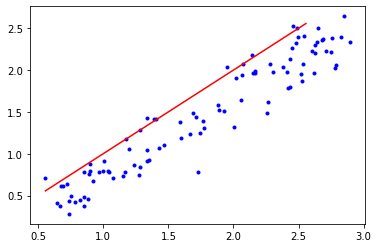

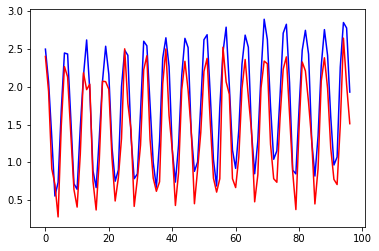

Final validation error is: 0.139412


In [11]:
plt.plot(tsty, mlp_model.predict(tstx), 'b.')
plt.plot(np.arange(min(tsty),max(tsty)+0.5),np.arange(min(tsty),max(tsty)+0.5), 'r')
plt.show()

plt.plot(range(tsty.shape[0]), tsty,'b-')
plt.plot(range(tsty.shape[0]), mlp_model.predict(tstx),'r-')
plt.show()
print("Final validation error is: %f" % history.history['val_mean_squared_error'][len(history.history['val_mean_squared_error'])-1])

In [12]:
batch_size = 10
sequence_length = 4
data_dim = 3

In [13]:
datax = data_matrix_np[0:data_matrix_np.shape[0]-1, 0:3]
datay = data_matrix_np[0:data_matrix_np.shape[0]-1:, 3]
print(datax.shape)
print(datay.shape)


(396, 3)
(396,)


In [14]:
datax = np.reshape(datax, (-1, sequence_length, data_dim))
datay = np.reshape(datay, (-1, sequence_length, 1))
print(datax.shape)
print(datay.shape)

(99, 4, 3)
(99, 4, 1)


In [15]:
trnx = datax[0:70, :]
trny = datay[0:70]
tstx = datax[70:datax.shape[0],:]
tsty = datay[70:datax.shape[0]]
print(trnx.shape)
print(tstx.shape)
print(trny.shape)
print(tsty.shape)

(70, 4, 3)
(29, 4, 3)
(70, 4, 1)
(29, 4, 1)


In [16]:
input_shape = (datax[0].shape)
input_tensor = layers.Input(input_shape)
print(input_shape)

(4, 3)


In [17]:
rnn_layer = layers.LSTM(10, return_sequences=True)(input_tensor)
output_tensor = layers.TimeDistributed(layers.Dense(1,activation='linear'))(rnn_layer)

In [18]:
model_mtom = models.Model(input_tensor, output_tensor)
model_mtom.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])

In [19]:
model_mtom.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 3)]            0         
                                                                 
 lstm (LSTM)                 (None, 4, 10)             560       
                                                                 
 time_distributed (TimeDistr  (None, 4, 1)             11        
 ibuted)                                                         
                                                                 
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model_mtom.fit(trnx, trny, validation_data = [tstx, tsty], batch_size = 10, epochs = 300)

Epoch 1/300
1/7 [===>..........................] - ETA: 7s - loss: 0.9092 - mean_squared_error: 0.9092

2022-05-10 21:00:19.034731: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


7/7 [==============================] - 1s 31ms/step - loss: 1.2504 - mean_squared_error: 1.2504 - val_loss: 3.0817 - val_mean_squared_error: 3.0817
Epoch 2/300
7/7 [==============================] - 0s 4ms/step - loss: 1.1878 - mean_squared_error: 1.1878 - val_loss: 2.8360 - val_mean_squared_error: 2.8360
Epoch 3/300
7/7 [==============================] - 0s 3ms/step - loss: 1.1281 - mean_squared_error: 1.1281 - val_loss: 2.6223 - val_mean_squared_error: 2.6223
Epoch 4/300
7/7 [==============================] - 0s 3ms/step - loss: 1.0805 - mean_squared_error: 1.0805 - val_loss: 2.4274 - val_mean_squared_error: 2.4274
Epoch 5/300
7/7 [==============================] - 0s 3ms/step - loss: 1.0321 - mean_squared_error: 1.0321 - val_loss: 2.2764 - val_mean_squared_error: 2.2764
Epoch 6/300
7/7 [==============================] - 0s 3ms/step - loss: 0.9969 - mean_squared_error: 0.9969 - val_loss: 2.1274 - val_mean_squared_error: 2.1274
Epoch 7/300
7/7 [==============================] - 0s 4ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1944 - mean_squared_error: 0.1944 - val_loss: 0.5222 - val_mean_squared_error: 0.5222
Epoch 53/300
7/7 [==============================] - 0s 4ms/step - loss: 0.1895 - mean_squared_error: 0.1895 - val_loss: 0.5137 - val_mean_squared_error: 0.5137
Epoch 54/300
7/7 [==============================] - 0s 5ms/step - loss: 0.1850 - mean_squared_error: 0.1850 - val_loss: 0.4882 - val_mean_squared_error: 0.4882
Epoch 55/300
7/7 [==============================] - 0s 3ms/step - loss: 0.1808 - mean_squared_error: 0.1808 - val_loss: 0.4745 - val_mean_squared_error: 0.4745
Epoch 56/300
7/7 [==============================] - 0s 3ms/step - loss: 0.1765 - mean_squared_error: 0.1765 - val_loss: 0.4733 - val_mean_squared_error: 0.4733
Epoch 57/300
7/7 [==============================] - 0s 4ms/step - loss: 0.1730 - mean_squared_error: 0.1730 - val_loss: 0.4502 - val_mean_squared_error: 0.4502
Epoch 58/300
7/7 [==============================] - 0

7/7 [==============================] - 0s 4ms/step - loss: 0.0917 - mean_squared_error: 0.0917 - val_loss: 0.2428 - val_mean_squared_error: 0.2428
Epoch 104/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.2388 - val_mean_squared_error: 0.2388
Epoch 105/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.2371 - val_mean_squared_error: 0.2371
Epoch 106/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0894 - mean_squared_error: 0.0894 - val_loss: 0.2354 - val_mean_squared_error: 0.2354
Epoch 107/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0886 - mean_squared_error: 0.0886 - val_loss: 0.2324 - val_mean_squared_error: 0.2324
Epoch 108/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0880 - mean_squared_error: 0.0880 - val_loss: 0.2347 - val_mean_squared_error: 0.2347
Epoch 109/300
7/7 [=============================

Epoch 154/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0678 - mean_squared_error: 0.0678 - val_loss: 0.1911 - val_mean_squared_error: 0.1911
Epoch 155/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0674 - mean_squared_error: 0.0674 - val_loss: 0.1962 - val_mean_squared_error: 0.1962
Epoch 156/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0670 - mean_squared_error: 0.0670 - val_loss: 0.1934 - val_mean_squared_error: 0.1934
Epoch 157/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0667 - mean_squared_error: 0.0667 - val_loss: 0.1930 - val_mean_squared_error: 0.1930
Epoch 158/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0664 - mean_squared_error: 0.0664 - val_loss: 0.1924 - val_mean_squared_error: 0.1924
Epoch 159/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0662 - mean_squared_error: 0.0662 - val_loss: 0.1944 - val_mean_squared_error: 0.1944
Epoch 160/300
7/7 [===============

Epoch 205/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - val_loss: 0.1717 - val_mean_squared_error: 0.1717
Epoch 206/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0562 - mean_squared_error: 0.0562 - val_loss: 0.1730 - val_mean_squared_error: 0.1730
Epoch 207/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0560 - mean_squared_error: 0.0560 - val_loss: 0.1720 - val_mean_squared_error: 0.1720
Epoch 208/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0559 - mean_squared_error: 0.0559 - val_loss: 0.1699 - val_mean_squared_error: 0.1699
Epoch 209/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - val_loss: 0.1713 - val_mean_squared_error: 0.1713
Epoch 210/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - val_loss: 0.1706 - val_mean_squared_error: 0.1706
Epoch 211/300
7/7 [===============

Epoch 256/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0493 - mean_squared_error: 0.0493 - val_loss: 0.1634 - val_mean_squared_error: 0.1634
Epoch 257/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.1555 - val_mean_squared_error: 0.1555
Epoch 258/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.1547 - val_mean_squared_error: 0.1547
Epoch 259/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.1601 - val_mean_squared_error: 0.1601
Epoch 260/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.1535 - val_mean_squared_error: 0.1535
Epoch 261/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0487 - mean_squared_error: 0.0487 - val_loss: 0.1590 - val_mean_squared_error: 0.1590
Epoch 262/300
7/7 [===============

ValueError: x and y can be no greater than 2D, but have shapes (29, 4, 1) and (29, 4, 1)

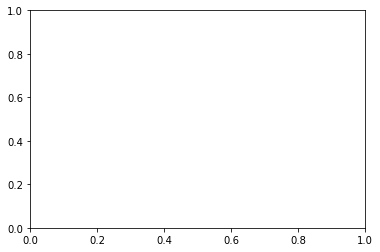

In [21]:
plt.plot(tsty, model_mtom.predict(tstx), 'b.')
plt.plot(np.arange(min(tsty),max(tsty)+1),np.arange(min(tsty),max(tsty)+1), 'r')
plt.show()

plt.plot(range(tsty.shape[0]), tsty,'b-')
plt.plot(range(tsty.shape[0]), model_mtom.predict(tstx),'r-')
plt.show()
print("Final validation error is: %f" % history.history['val_mean_squared_error'][len(history.history['val_mean_squared_error'])-1])

In [22]:
plt.plot(tmp, np.reshape(model_mtom.predict(tstx), (-1,1)), 'b.')
plt.plot(np.arange(min(tmp),max(tmp)+0.5), np.arange(min(tmp),max(tmp)+0.5), 'r')
plt.show()

plt.plot(range(tmp.shape[0]), tmp,'b-')
plt.plot(range(tmp.shape[0]), np.reshape(model_mtom.predict(tstx), (-1,1)),'r-')
plt.show()
print("Final validation error is: %f" % history.history['val_mean_squared_error'][len(history.history['val_mean_squared_error'])-1])

NameError: name 'tmp' is not defined

In [23]:
#Many to One
data_time.shape

(400,)

In [24]:
data_matrix = []
seq_len = 3
for i in range(0, len(data_time)-data_dim*sequence_length):
    tmp_data = data_time[i:i+data_dim*sequence_length+1]
    data_matrix.append(tmp_data)
    
data_matrix_np = np.array(data_matrix)
print(data_matrix_np.shape)
print(data_matrix_np)

(388, 13)
[[-0.16808225  0.89805117  0.75624254 ... -0.49588909 -0.97196549
  -0.43816176]
 [ 0.89805117  0.75624254 -0.02629723 ... -0.97196549 -0.43816176
   0.64791494]
 [ 0.75624254 -0.02629723 -0.81238928 ... -0.43816176  0.64791494
   1.17055636]
 ...
 [ 2.7463765   2.43153173  1.28330419 ...  1.07098207  2.2604337
   2.84962681]
 [ 2.43153173  1.28330419  0.82010165 ...  2.2604337   2.84962681
   2.77727206]
 [ 1.28330419  0.82010165  1.35225482 ...  2.84962681  2.77727206
   1.92996187]]


In [25]:
datax = data_matrix_np[0:data_matrix_np.shape[0]-1,0:12]
datay = data_matrix_np[0:data_matrix_np.shape[0]-1,12]
print(datax.shape)
print(datay.shape)

(387, 12)
(387,)


In [26]:
datax = np.reshape(datax, (-1, sequence_length, data_dim))
print(datax.shape)
print(datay.shape)

(387, 4, 3)
(387,)


In [27]:
trnx = datax[0:300, :]
trny = datay[0:300]
tstx = datax[300:datax.shape[0], :]
tsty = datay[300:datax.shape[0]]
print(trnx.shape)
print(tstx.shape)
print(trny.shape)
print(tsty.shape)

(300, 4, 3)
(87, 4, 3)
(300,)
(87,)


In [28]:
input_shape = (trnx[0].shape)
input_tensor = layers.Input(input_shape)

In [29]:
rnn_layer = layers.LSTM(10)(input_tensor)
output_tensor = layers.Dense(1, activation = "linear")(rnn_layer)

In [30]:
model_mtoo = models.Model(input_tensor, output_tensor)
model_mtoo.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])

In [31]:
model_mtoo.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 3)]            0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                560       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model_mtoo.fit(trnx, trny, validation_data = [tstx, tsty], batch_size = 10, epochs = 300)

Epoch 1/300
30/30 [==============================] - 1s 14ms/step - loss: 1.8382 - mean_squared_error: 1.8382 - val_loss: 3.9025 - val_mean_squared_error: 3.9025
Epoch 2/300
30/30 [==============================] - 0s 2ms/step - loss: 1.1349 - mean_squared_error: 1.1349 - val_loss: 2.2889 - val_mean_squared_error: 2.2889
Epoch 3/300
30/30 [==============================] - 0s 3ms/step - loss: 0.7360 - mean_squared_error: 0.7360 - val_loss: 1.3521 - val_mean_squared_error: 1.3521
Epoch 4/300
30/30 [==============================] - 0s 3ms/step - loss: 0.5702 - mean_squared_error: 0.5702 - val_loss: 0.9026 - val_mean_squared_error: 0.9026
Epoch 5/300
30/30 [==============================] - 0s 2ms/step - loss: 0.5068 - mean_squared_error: 0.5068 - val_loss: 0.7429 - val_mean_squared_error: 0.7429
Epoch 6/300
30/30 [==============================] - 0s 2ms/step - loss: 0.4661 - mean_squared_error: 0.4661 - val_loss: 0.6605 - val_mean_squared_error: 0.6605
Epoch 7/300
30/30 [==============

30/30 [==============================] - 0s 4ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0615 - val_mean_squared_error: 0.0615
Epoch 52/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0575 - val_mean_squared_error: 0.0575
Epoch 53/300
30/30 [==============================] - 0s 3ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0670 - val_mean_squared_error: 0.0670
Epoch 54/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0658 - val_mean_squared_error: 0.0658
Epoch 55/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0509 - val_mean_squared_error: 0.0509
Epoch 56/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0474 - val_mean_squared_error: 0.0474
Epoch 57/300
30/30 [=====================

30/30 [==============================] - 0s 3ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 102/300
30/30 [==============================] - 0s 3ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 103/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0268 - val_mean_squared_error: 0.0268
Epoch 104/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 105/300
30/30 [==============================] - 0s 3ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0253 - val_mean_squared_error: 0.0253
Epoch 106/300
30/30 [==============================] - 0s 3ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0336 - val_mean_squared_error: 0.0336
Epoch 107/300
30/30 [===============

30/30 [==============================] - 0s 3ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 152/300
30/30 [==============================] - 0s 3ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 153/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
Epoch 154/300
30/30 [==============================] - 0s 3ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 155/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 156/300
30/30 [==============================] - 0s 6ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 157/300
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 202/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 203/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 204/300
30/30 [==============================] - 0s 4ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 205/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 206/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 207/300
30/30 [===============

30/30 [==============================] - 0s 4ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 252/300
30/30 [==============================] - 0s 3ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 253/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 254/300
30/30 [==============================] - 0s 4ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0161 - val_mean_squared_error: 0.0161
Epoch 255/300
30/30 [==============================] - 0s 3ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 256/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0274 - val_mean_squared_error: 0.0274
Epoch 257/300
30/30 [===============

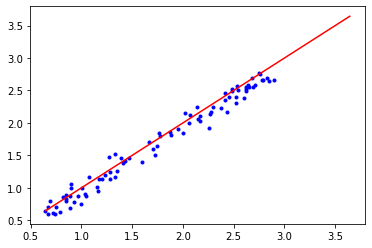

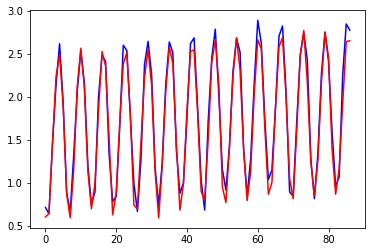

Final validation error is: 0.014952


In [33]:
plt.plot(tsty, model_mtoo.predict(tstx), 'b.')
plt.plot(np.arange(min(tsty),max(tsty)+1),np.arange(min(tsty),max(tsty)+1), 'r')
plt.show()

plt.plot(range(tsty.shape[0]), tsty,'b-')
plt.plot(range(tsty.shape[0]), model_mtoo.predict(tstx),'r-')
plt.show()
print("Final validation error is: %f" % history.history['val_mean_squared_error'][len(history.history['val_mean_squared_error'])-1])